<a href="https://colab.research.google.com/github/mancunian1792/LatentSpaceClustering_GenerativeModels/blob/main/cluster_GAN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.0
!pip install torchvision==0.2.1
!pip install pillow==6.0.0

     |████████████████████████████████| 591.8MB 29kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
     |████████████████████████████████| 61kB 3.4MB/s 
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 2.0MB 4.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
import torch
from torch import nn
import  torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10 # Training dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from itertools import chain
from torch.autograd import Variable
from tqdm.notebook import tqdm as tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics
import heapq
from torchvision.utils import make_grid
from itertools import product

In [2]:
print(torch.__version__)

1.0.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# Weight Initializer
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:

class Reshape(nn.Module):
    """
    Class for performing a reshape as a layer in a sequential model.
    """
    def __init__(self, shape=[]):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)
    
    def extra_repr(self):
            # (Optional)Set the extra information about this module. You can test
            # it by printing an object of this class.
            return 'shape={}'.format(
                self.shape
            )
# Encoder Network Class

class Encoder(nn.Module):
  '''
  Encoder model
  '''
  def __init__(self, image_shape, latent_dim, num_classes):
    super(Encoder, self).__init__()
    self.num_channels = image_shape[0]
    self.latent_dim = latent_dim
    self.num_classes = num_classes
    self.img_shape = (image_shape[1], image_shape[2])
    self.conv_shape = (128, 5, 5) # Shape after convolution - Can we figure it out automatically ?
    self.iels = int(np.prod(self.conv_shape))
    self.lshape = (self.iels,)

    # Convolutional Block
    self.conv = nn.Sequential(
        nn.Conv2d(self.num_channels, 64, 4, stride = 2, bias = True),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, stride =2, bias = True),
        nn.LeakyReLU(0.2)
    )
    # Flatten Block
    self.reshape = Reshape(self.lshape)

    # Fully Connected Layers
    self.fc = nn.Sequential(
        nn.Linear(self.iels, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.latent_dim + self.num_classes)
    )
    initialize_weights(self)

  def forward(self, img):
    conv_img = self.conv(img)
    reshape_img = self.reshape(conv_img)
    z_img = self.fc(reshape_img) # (batch_size , 40)
    
    z = z_img.view(z_img.shape[0], -1)
    # Separate continuous and one-hot components
    zn = z[:, 0:self.latent_dim] # bs, 30
    zc_logits = z[:, self.latent_dim:] # bs, 10
    # Softmax on zc component
    zc = F.softmax(zc_logits, dim=1)
    return zn, zc, zc_logits


# Generator Network Class
class Generator(nn.Module):
  def __init__(self, latent_dim, num_classes, image_shape):
    super(Generator, self).__init__()

    self.latent_dim = latent_dim
    self.num_classes = num_classes
    self.image_shape = image_shape

    self.ishape = (128, 7, 7)
    self.iels = int(np.prod(self.ishape))

    #Full connected layers
    self.fc = nn.Sequential(
        nn.Linear(self.latent_dim + self.num_classes, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.iels),
        nn.BatchNorm1d(self.iels),
        nn.LeakyReLU(0.2),
    )

    #reshape
    self.reshape = Reshape(self.ishape)

    #Upconvolution Layers
    self.upconv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, image_shape[0], 4, stride=2, padding=1, bias=True),
        nn.Sigmoid()
    )
    initialize_weights(self)
  def forward(self, zn, zc):
    z = torch.cat((zn, zc), 1)

    fc_img = self.fc(z)
    reshape_img = self.reshape(fc_img)
    x_gen = self.upconv(reshape_img)
    # Reshape for output
    x_gen = x_gen.view(x_gen.size(0), *self.image_shape)
    return x_gen

# Discriminator Network Class
class Discriminator(nn.Module):
  def __init__(self, image_shape):

    super(Discriminator, self).__init__()

    self.channels = image_shape[0]
    self.cshape = (128, 5, 5)
    self.iels = int(np.prod(self.cshape))
    self.lshape = (self.iels,) 

    # Convolutional Layers
    self.conv = nn.Sequential(
        nn.Conv2d(self.channels, 64, 4, stride=2, bias=True),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, stride=2, bias=True),
        nn.LeakyReLU(0.2),
    )

    # Flatten
    self.flatten = Reshape(self.lshape)

    # Fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(self.iels, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 1),
        nn.Sigmoid()
    )
    initialize_weights(self)
  def forward(self, img):
    conv_img = self.conv(img)
    flatten_img = self.flatten(conv_img)
    validity = self.fc(flatten_img)

    return validity


In [6]:
n_epochs = 150
test_batch_size = 5000
lr = 1e-4 #learning rate for both optimizers.
b1 = 0.5 # default - associated with optimizer to calculate gradient.
b2 = 0.9 #0.99 default - associated with optimizer to calculate gradient.
decay = 2.5*1e-5 # decay rate optimizer. 
n_skip_iter = 1 #5 When does my encoder and generator train
latent_dim = 30
num_classes = 10
batch_size = 64
betan = 10 # Beta associated with clustering  loss (From the loss function mentioned in paper)
betac = 10 # Beta associated with the cross entropy (From the loss function mentioned in paper)


In [31]:
dataset_type = "cifar"
img_size = 28
channels = 3 if dataset_type == "cifar" else 1
image_shape = (channels, img_size, img_size)

DATA = MNIST if dataset_type == "mnist" else FashionMNIST if dataset_type == "fashion" else CIFAR10

transform_data = transforms.Compose([transforms.Resize(size=(28, 28)), transforms.ToTensor()])  if dataset_type in "cifar" else transforms.ToTensor()

dataloader = DataLoader(
    DATA('.', download=True, transform=transform_data),
    batch_size=batch_size,
    shuffle=True)

train_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)


test_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=False)
test_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)

Files already downloaded and verified


In [8]:
def sample_zs(batch_size, latent_dim, num_classes, cuda = True, fix_class = -1, req_grad = False):
  '''
  create a zn from random normal -> (bs, latent_dim)
  '''
  assert (fix_class == -1 or (fix_class >= 0 and fix_class < num_classes) ), "Requested class %i outside bounds."%fix_class
  shape = batch_size
  Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
  
  # Sample noise as generator input, zn
  zn = Variable(Tensor(0.75*np.random.normal(0, 1, (shape, latent_dim))), requires_grad=req_grad)

  ######### zc, zc_idx variables with grads, and zc to one-hot vector
  # Pure one-hot vector generation
  zc_FT = Tensor(shape, num_classes).fill_(0) # Filling it with 0
  zc_idx = torch.empty(shape, dtype=torch.long) # empty torch tensor with shape (bs,)
  zc_idx = zc_idx.cuda() if cuda else zc_idx
  zc_FT = zc_FT.cuda() if cuda else zc_FT
  
  if (fix_class == -1): # During training
      zc_idx = zc_idx.random_(num_classes)# Random classes between  with shape (bs, )
      zc_FT = zc_FT.scatter_(1, zc_idx.unsqueeze(1), 1.)
  else: # Conditional generation
      zc_idx[:] = fix_class
      zc_FT[:, fix_class] = 1

  
  zc = Variable(zc_FT, requires_grad=req_grad)
  return zn, zc, zc_idx

### Train method



In [9]:
def train(dataset_type):

  encoder = Encoder(image_shape=image_shape, 
                    latent_dim=latent_dim, 
                    num_classes=num_classes)

  generator = Generator(image_shape=image_shape, 
                        latent_dim=latent_dim,
                        num_classes=num_classes)

  discriminator = Discriminator(image_shape=image_shape)

  # Loss function
  bce_loss = nn.BCELoss() # Discriminator loss
  xe_loss = nn.CrossEntropyLoss() # cross _entropy loss to associate the z vectors to correct label.
  mse_loss = nn.MSELoss() # Clustering loss to associate the z vectors of same label close together.

  cuda = True if torch.cuda.is_available() else False
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  gen_enc_losses = []
  disc_losses = []
  if cuda:
    generator.to(device)
    encoder.to(device)
    discriminator.to(device)
    bce_loss.to(device)
    xe_loss.to(device)
    mse_loss.to(device)

  ge_chain = chain(generator.parameters(),
                        encoder.parameters())

  optimizer_GE = torch.optim.Adam(ge_chain, lr=lr, betas=(b1, b2), weight_decay=decay)
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
  Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

  for epoch in tqdm(range(n_epochs)):
    for batch_num, (real_imgs, real_labels) in enumerate(train_loader):
      real_imgs = Variable(real_imgs.type(Tensor))
      # We put generator and encoder in training mode.
      # Generator need -> Some noise to start with (batch_size, latent_dim + num_classes) -> Fake image.
      # Encoder needs the fake image generated by generator get the z that would have created the fake image.
      generator.train()
      encoder.train()
      generator.zero_grad()
      encoder.zero_grad()
      discriminator.zero_grad()
      optimizer_GE.zero_grad()
      zn, zc, zc_idx = sample_zs(real_imgs.shape[0], latent_dim, num_classes, cuda=cuda)
      # Generator uses the zn and zc to produce fake image
      fake_image = generator(zn, zc)
      fake_img_enc = fake_image.clone()
      fake_img_disc = fake_image.clone()

      
      fake_output = discriminator(fake_img_disc)
      real_output = discriminator(real_imgs)
      encoder_zn, encoder_zc, encoder_logits = encoder(fake_img_enc)

      # Get the losses.
      # mse loss, xe loss and bce_loss
      zn_loss = mse_loss(encoder_zn, zn)
      zc_loss = xe_loss(encoder_logits, zc_idx)
      real_tensor = Variable(Tensor(fake_image.size(0), 1).fill_(1.0), requires_grad=False)
      bc_loss = bce_loss(fake_output, real_tensor)
      ge_loss = bc_loss + (betan * zn_loss) + (betac * zc_loss)
      # Backpropogate generator and encoder.
      ge_loss.backward(retain_graph=True)
      optimizer_GE.step()
    
      # Backpropogate for discriminator
      # This should clear out the prev grad attribute.
      optimizer_D.zero_grad()
      fake_tensor = Variable(Tensor(fake_image.size(0), 1).fill_(0.0), requires_grad=False)
      fake_loss =  bce_loss(fake_output, fake_tensor)
      real_loss = bce_loss(real_output, real_tensor)
      discriminator_loss = (fake_loss + real_loss)/2
      discriminator_loss.backward()
      optimizer_D.step()
      
      
    
    gen_enc_losses.append(ge_loss.item())
    disc_losses.append(discriminator_loss.item())
    
    print(f" Epoch number {epoch} -- Generator-Encoder loss is {ge_loss.item()} -- Discriminator Loss is {discriminator_loss.item()}")

    if epoch % 50 == 0:
      # save generator, encoder and discriminator model weights every 10 epoch
      torch.save(generator.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'generator_model.pth')
      torch.save(encoder.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'encoder_model.pth')
      torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/'+dataset_type+'discriminator_model.pth')
      

### Training the cluster GAN model

In [ ]:
train("cifar")

 Epoch number 0 -- Generator-Encoder loss is 1.2751096487045288 -- Discriminator Loss is 0.6567543745040894
 Epoch number 1 -- Generator-Encoder loss is 1.5872769355773926 -- Discriminator Loss is 0.6188747882843018
 Epoch number 2 -- Generator-Encoder loss is 2.365851640701294 -- Discriminator Loss is 0.6781853437423706
 Epoch number 3 -- Generator-Encoder loss is 1.0446395874023438 -- Discriminator Loss is 0.6709855794906616
 Epoch number 4 -- Generator-Encoder loss is 1.406813144683838 -- Discriminator Loss is 0.5620918869972229
 Epoch number 5 -- Generator-Encoder loss is 1.446660041809082 -- Discriminator Loss is 0.6577155590057373
 Epoch number 6 -- Generator-Encoder loss is 1.1351431608200073 -- Discriminator Loss is 0.728217601776123
 Epoch number 7 -- Generator-Encoder loss is 1.2543853521347046 -- Discriminator Loss is 0.5892153978347778
 Epoch number 8 -- Generator-Encoder loss is 1.4650225639343262 -- Discriminator Loss is 0.5326259136199951
 Epoch number 9 -- Generator-Enc

### Visualizing the Clustering Space

1. Loading the model

In [32]:
encoder = Encoder(image_shape=image_shape, 
                    latent_dim=latent_dim, 
                    num_classes=num_classes)

encoder.load_state_dict(torch.load('/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/cifarencoder_model.pth'))
encoder.eval()

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
  )
  (reshape): Reshape(shape=(3200,))
  (fc): Sequential(
    (0): Linear(in_features=3200, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1024, out_features=40, bias=True)
  )
)

In [33]:
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(train_loader))
    imgs_.append(imgs)
    labels_.append(labels)
imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

In [12]:
def get_data(dataset_type):
  img_size = 28
  channels = 3 if dataset_type == "cifar" else 1
  image_shape = (channels, img_size, img_size)

  DATA = MNIST if dataset_type == "mnist" else FashionMNIST if dataset_type == "fashion" else CIFAR10

  transform_data = transforms.Compose([transforms.Resize(size=(28, 28)), transforms.ToTensor()])  if dataset_type in "cifar" else transforms.ToTensor()

  dataloader = DataLoader(
      DATA('.', download=True, transform=transform_data),
      batch_size=batch_size,
      shuffle=True)

  train_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=True)
  train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)


  test_dataset = DATA('./'+ dataset_type+'/', download= True, transform= transform_data, train=False)
  test_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= False)
  imgs_ = []
  labels_ = []
  for i in range(100):
      imgs, labels = next(iter(train_loader))
      imgs_.append(imgs)
      labels_.append(labels)
  imgs = torch.cat(imgs_, dim = 0)
  labels = torch.cat(labels_, dim = 0)
  return imgs

In [13]:
imgs.shape

torch.Size([6400, 1, 28, 28])

In [14]:
test_imgs_ = []
test_labels_ = []
for i in range(100):
  imgs_, labels_ = next(iter(test_loader))
  test_imgs_.append(imgs_)
  test_labels_.append(labels_)
test_imgs = torch.cat(test_imgs_, dim=0)
test_labels = torch.cat(test_labels_, dim=0)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)
enc_zn, enc_zc, enc_zc_logits = encoder(imgs)
enc = np.hstack((enc_zn.cpu().detach().numpy(), enc_zc_logits.cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.032s...
[t-SNE] Computed neighbors for 6400 samples in 1.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 3.674257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.092331
[t-SNE] KL divergence after 1000 iterations: 1.302472


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

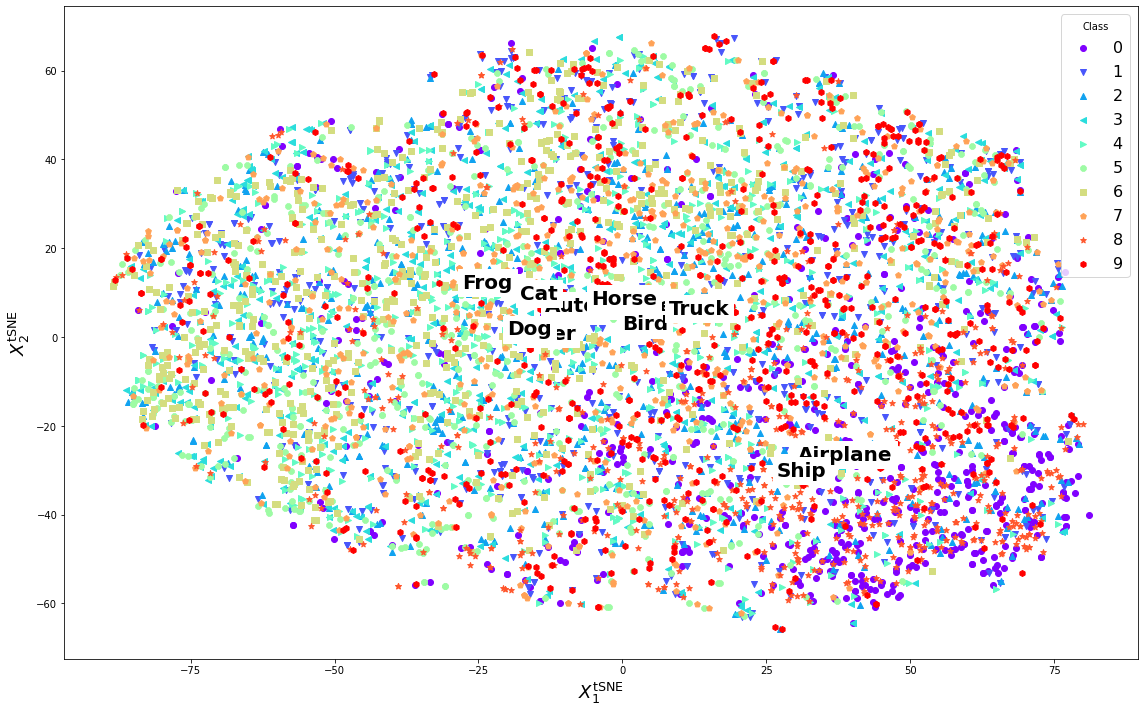

In [ ]:
nr_c = 10
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers
class_labels = ["T-shirt/top", "Trouser" ,"Pullover", "Dress" ,"Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] if dataset_type == "fashion" else ["0","1", "2", "3","4","5","6","7","8","9"] if dataset_type == "mnist" else ["Airplane", "Automobile" ,"Bird", "Cat" ,"Deer","Dog", "Frog", "Horse", "Ship", "Truck"]
    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.annotate(class_labels[iclass], 
                 np.median([tsne_enc[idxs ,0], tsne_enc[idxs ,1]], axis=1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='black',
                 backgroundcolor='white') 
    plt.tight_layout()
    fig.savefig('tsne-pca.png')

### Testing Generation

In [34]:
generator = Generator(image_shape=image_shape, 
                        latent_dim=latent_dim,
                        num_classes=num_classes)
generator.load_state_dict(torch.load('/content/gdrive/MyDrive/latent_space_clustering/cluster_gan_simple/harish_runs/cifargenerator_model.pth'))
generator.to('cuda:0')
generator.eval()



Generator(
  (fc): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (reshape): Reshape(shape=(128, 7, 7))
  (upconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [ ]:
zn, zc, zc_idx = sample_zs(1, latent_dim=30, num_classes=10, cuda=True, fix_class=4)
gen_img = generator(zn, zc)

In [ ]:
gen_img.shape

torch.Size([1, 1, 28, 28])

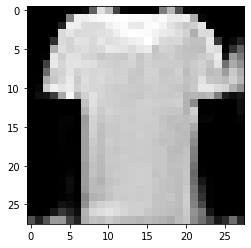

In [ ]:
reshape_img = gen_img.squeeze(0).permute(1,2,0).detach().cpu() if dataset_type == "cifar" else gen_img.detach().cpu().reshape((28,28))
plt.imshow(reshape_img.reshape((28,28))) if dataset_type =="cifar" else plt.imshow(reshape_img, cmap="gray")

### Testing Reconstruction

In [38]:
sample_img = imgs[16:32]

In [39]:
zn, zc, zc_idx = encoder(sample_img)
reconstructed_img = generator(zn.cuda(), zc.cuda())


Text(0.5, 0, 'Reconstructed Images')

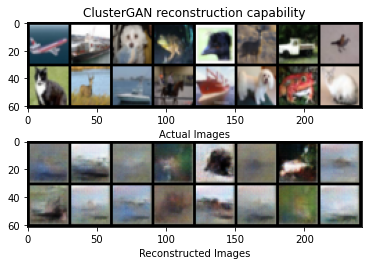

In [40]:
plt.subplot(2,1,1)
plt.title("ClusterGAN reconstruction capability")
show_image(make_grid(sample_img.detach().cpu(), 8, 2))
plt.xlabel("Actual Images")
plt.subplot(2,1,2)
show_image(make_grid(reconstructed_img.detach().cpu(), 8, 2))
plt.xlabel("Reconstructed Images")


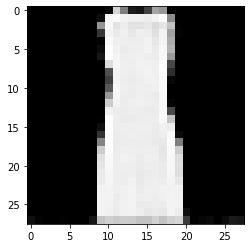

In [ ]:
plt.imshow(reconstructed_img.reshape((28,28)).detach().cpu(), cmap='gray')

### Computing the clustering metrics

In [ ]:
# accepts latent space from cluster GAN and vae and evaluates it. estimator - kmeans
def bench_latent_spaces(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean'),
             metrics.davies_bouldin_score(data, estimator.labels_)))
    return estimator.labels_

In [ ]:
predicted_labels = bench_latent_spaces(KMeans(n_clusters=10,init='k-means++',max_iter=1000, random_state=0), 'clustergan', tsne_enc)

clustergan	0.38s	1800077	0.060	0.060	0.060	0.030	0.058	0.358	0.823


In [ ]:
#from scipy.optimize import linear_sum_assignment
from sklearn.utils.linear_assignment_ import linear_assignment
def clustering_acc(y_pred, y_true):
    D = int(max(y_pred.max(), y_true.max()) + 1)
    w = np.zeros((D, D), dtype=np.int32)
    for i in range(y_pred.size):
        idx1 = int(y_pred[i])
        idx2 = int(y_true[i])
        w[idx1, idx2] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
clustering_acc(predicted_labels, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.174375

In [ ]:
enc.shape

(6400, 40)

### Recommendation - Similar Images

Img -> Encoder -> Z -> Z+small_noise -> Generator -> Similar Image

In [ ]:
def generate_similar_image(img, encoder, generator, deviation_param=0.02):
  img = img.unsqueeze(0)
  enc_zn, enc_zc, enc_logits = encoder(img)
  new_enc_zn = enc_zn + torch.normal(mean=torch.zeros_like(enc_zn), std = deviation_param * torch.ones_like(enc_zn))
  new_enc_zc = enc_zc + torch.normal(mean=torch.zeros_like(enc_zc), std = deviation_param * torch.ones_like(enc_zc))
  similar_image = generator(new_enc_zn.cuda(), new_enc_zc.cuda())
  plt.subplot(1,2,2)
  plt.imshow(similar_image.reshape((28,28)).detach().cpu(), cmap='gray')
  plt.xlabel("Similar Image")
  plt.subplot(1,2,1)
  plt.imshow(img.reshape((28,28)).detach().cpu(), cmap="gray")
  plt.xlabel("Original Image")
  plt.ylabel(f"Adding noise with std {deviation_param} to the latent vector")

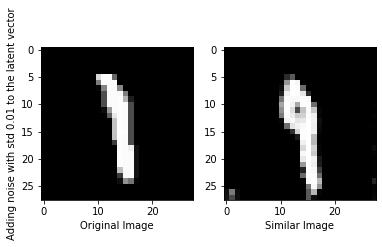

In [ ]:
generate_similar_image(imgs[110], encoder, generator, deviation_param=0.01)

### Recommending Top K similar images that are in the dataset.

In [ ]:
def recommend_k_similar_images(img,encoder, other_imgs, k=5):
  img = img.unsqueeze(0) 
  img_zn, img_zc, img_logits = encoder(img)
  other_zn, other_zc, other_logits = encoder(other_imgs)
  similarity_dict = {}
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  for idx in range(other_imgs.shape[0]):
    img_vec = torch.cat([img_zn, img_zc], dim=1)
    compare_img_vec = torch.cat([other_zn[idx, :].unsqueeze(0), other_zc[idx, :].unsqueeze(0)], dim=1)
    similarity_dict[idx] = cos(img_vec, compare_img_vec).item()
  k_keys_sorted_by_values = heapq.nlargest(k, similarity_dict, key=similarity_dict.get)
  return other_imgs[k_keys_sorted_by_values, :]

In [ ]:
# show original images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [18]:
# show original images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_recommended_images(given_img, encoder, other_imgs, how_many=5):
  rec_imgs = recommend_k_similar_images(given_img, encoder, other_imgs, k=how_many)
  plt.subplot(1,2,1)
  plt.imshow(given_img.reshape((28,28)).detach().cpu(), cmap="gray")
  plt.xlabel("Actual Image")
  plt.title(f"Recommending {how_many} images based on cosine similarity of latent vectors")
  plt.subplot(1,2,2)
  show_image(make_grid(rec_imgs.detach().cpu(), how_many, 1))
  plt.xlabel("Recommended Images")


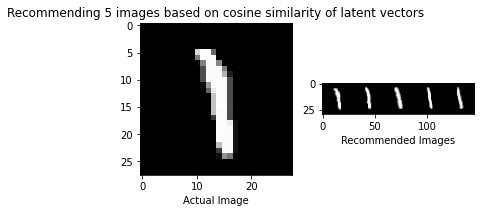

In [ ]:
show_recommended_images(imgs[110], encoder, imgs)

### Anomaly Detection

In [ ]:
def anomaly_loss(img, encoder, generator, lamda = 0.1):
  '''
  Discrimination_Loss = difference between the latent that would have
  generated the image and the latent of actual image
  Residual Loss = Reconstruction loss between the actual image and
  the generated image.
  Total anomaly loss is lambda * Discrimination_Loss +
                             (1-lambda) * Residual Loss
  '''
  loss = nn.L1Loss()
  zn, zc, zc_logits = encoder(img)
  generated_img = generator(zn.cuda(), zc.cuda())

  zn_gen, zc_gen, zc_gen_logits = encoder(generated_img.detach().cpu())
  original_latent = torch.cat([zn, zc], dim=1).detach().cpu()
  generated_latent = torch.cat([zn_gen, zc_gen], dim=1).detach().cpu()
  anomaly_loss = lamda * loss(original_latent, generated_latent).item() + \
                  (1-lamda) * loss(img.detach().cpu(), generated_img.detach().cpu())
  return anomaly_loss.item()




In [ ]:
mnist_data = get_data("mnist")
fashion_data = get_data("fashion")

In [ ]:
def anomaly_losses_report(train_imgs, test_imgs, encoder, generator, lamda, visualize=False, fake=True):
  train_anomaly_losses = []
  test_anomaly_losses = []
  for idx in range(imgs.shape[0]):
    train_anomaly_losses.append(anomaly_loss(train_imgs[idx, :].unsqueeze(0), encoder, generator, lamda=lamda))
  for idx in range(imgs.shape[0]):
    test_anomaly_losses.append(anomaly_loss(test_imgs[idx, :].unsqueeze(0), encoder, generator, lamda=lamda))
  threshold = max(train_anomaly_losses)
  prediction = [1 if loss > threshold else 0 for loss in test_anomaly_losses]
  actual = [1 if fake else 0 for loss in test_anomaly_losses]
  f1 = metrics.f1_score(actual, prediction)
  accuracy = metrics.accuracy_score(actual, prediction)
  if visualize:
    plt.scatter(list(range(len(train_anomaly_losses))), train_anomaly_losses, label="Train Loss")
    plt.scatter(list(range(len(test_anomaly_losses))), test_anomaly_losses, label="Test Loss")
    plt.axhline(y=threshold,linestyle='-', color='r')
    plt.xlabel("Images")
    plt.ylabel("Anomaly Losses")
    plt.legend()
  
  return f1, accuracy

In [ ]:
anomaly_losses_report(mnist_data, fashion_data, encoder, generator, 0.1)

The f1 score is 0.8663537330617306


0.8663537330617306

In [ ]:
def get_best_lamda():
  lamda = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
  f1 = [anomaly_losses_report(mnist_data, fashion_data, encoder, generator, ll) for ll in lamda]
  plt.plot(lamda, f1)
  plt.xlabel("Different lambda")
  plt.ylabel("F1 score")
  plt.title("Selecting the best lamda")

The f1 score is 0.875021972227105
The f1 score is 0.8663537330617306
The f1 score is 0.7473086709727931
The f1 score is 0.5574213907359404
The f1 score is 0.2825707768683751
The f1 score is 0.07460890493381468
The f1 score is 0.011804908356632495
The f1 score is 0.00529842605578931
The f1 score is 0.0034316019341756356
The f1 score is 0.002808550475893275
The f1 score is 0.002808550475893275


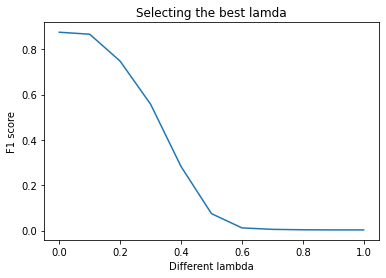

In [ ]:
get_best_lamda()

In [ ]:
anomaly_loss(imgs[20].unsqueeze(0), encoder, generator)

tensor(0.1144)

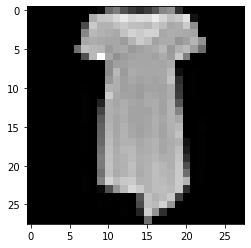

In [ ]:
plt.imshow(imgs[200].detach().cpu().reshape(28,28), cmap="gray")

In [ ]:
mnist_data = get_data("mnist")

In [ ]:
def corrupt_train_images(imgs, mean, std, encoder, generator):
  corrupt_imgs = imgs + torch.normal(mean=torch.zeros_like(imgs), std = std * torch.ones_like(imgs))
  return anomaly_losses_report(imgs, corrupt_imgs, encoder, generator, 0, fake= False)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.001, encoder, generator)

(0.0, 0.99984375)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.1, encoder, generator)

(0.0, 0.9125)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.11, encoder, generator)

(0.0, 0.8090625)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.12, encoder, generator)

(0.0, 0.64796875)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.13, encoder, generator)

(0.0, 0.455625)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.14, encoder, generator)

(0.0, 0.27265625)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.15, encoder, generator)

(0.0, 0.1303125)

In [ ]:
corrupt_train_images(mnist_data, 1, 0, encoder, generator)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


(0.0, 1.0)

In [ ]:
corrupt_train_images(mnist_data, 2, 0, encoder, generator)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


(0.0, 1.0)

In [ ]:
def plot_varied_data(imgs, mean, std):
  corrupt_imgs = imgs + torch.normal(mean=torch.zeros_like(imgs), std = std * torch.ones_like(imgs))
  plt.subplot(2,1,1)
  show_image(make_grid(imgs[0:16, :].detach().cpu(), 8, 2))
  plt.xlabel("Normal Image")
  plt.subplot(2,1,2)
  show_image(make_grid(corrupt_imgs[0:16, :].detach().cpu(), 8, 2))
  plt.xlabel(f"Corrupted Image with N{mean, std} noise")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


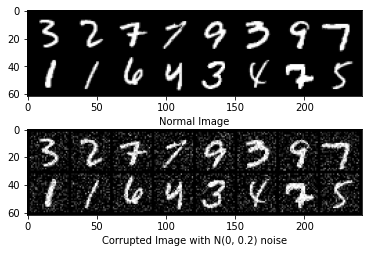

In [ ]:
plot_varied_data(mnist_data, 0, 0.2)

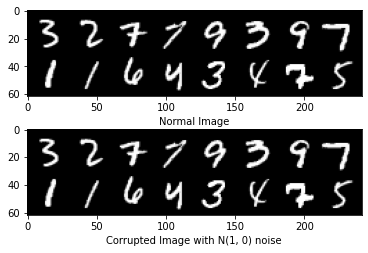

In [ ]:
plot_varied_data(mnist_data, 1, 0)

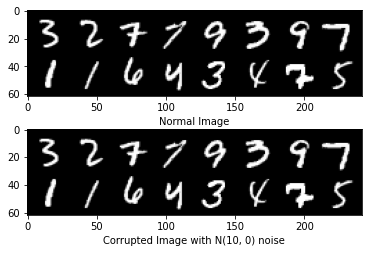

In [ ]:
plot_varied_data(mnist_data, 10, 0)

Text(0.5, 1.0, 'Zero Mean, positive standard deviation noise impact on accuracy')

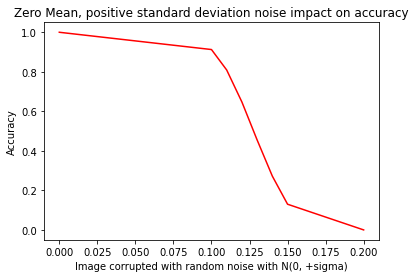

In [ ]:
acc = [1, 0.999, 0.9125, 0.809, 0.647, 0.455, 0.272, 0.130, 0]
std = [0, 0.001, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2]
plt.plot(std, acc, color='r')
plt.xlabel('Image corrupted with random noise with N(0, +sigma)')
plt.ylabel('Accuracy')
plt.title('Zero Mean, positive standard deviation noise impact on accuracy')

In [ ]:
corrupt_train_images(mnist_data, 0, 0.2, encoder, generator)

(0.0, 0.0)

In [ ]:
corrupt_train_images(mnist_data, 0, 0.3, encoder, generator)

(0.0, 0.0)

In [ ]:
def deviate_train_images(imgs, encoder, generator):
  mean = [0, 0.5, 1, 5, 10]
  std = [0, 0.5, 1, 5, 10]
  all_comb = list(product(mean, std))
  f1_dict = {}
  acc_dict = {}
  for comb in tqdm(all_comb):
    f1, acc = corrupt_train_images(imgs, comb[0], comb[1], encoder, generator)
    f1_dict[str(comb)] = f1
    acc_dict[str(comb)] = acc
  return f1_dict, acc_dict


In [ ]:
f1_d, acc_d = deviate_train_images(mnist_data, encoder, generator)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [ ]:
acc_d

{'(0, 0)': 1.0,
 '(0, 0.5)': 0.0,
 '(0, 1)': 0.0,
 '(0, 10)': 0.0,
 '(0, 5)': 0.0,
 '(0.5, 0)': 1.0,
 '(0.5, 0.5)': 0.0,
 '(0.5, 1)': 0.0,
 '(0.5, 10)': 0.0,
 '(0.5, 5)': 0.0,
 '(1, 0)': 1.0,
 '(1, 0.5)': 0.0,
 '(1, 1)': 0.0,
 '(1, 10)': 0.0,
 '(1, 5)': 0.0,
 '(10, 0)': 1.0,
 '(10, 0.5)': 0.0,
 '(10, 1)': 0.0,
 '(10, 10)': 0.0,
 '(10, 5)': 0.0,
 '(5, 0)': 1.0,
 '(5, 0.5)': 0.0,
 '(5, 1)': 0.0,
 '(5, 10)': 0.0,
 '(5, 5)': 0.0}

In [ ]:
mean = [0, 0.5, 1, 5, 10]
std = [0, 0.5, 1, 5, 10]
list(product(mean, std))

[(0, 0),
 (0, 0.5),
 (0, 1),
 (0, 5),
 (0, 10),
 (0.5, 0),
 (0.5, 0.5),
 (0.5, 1),
 (0.5, 5),
 (0.5, 10),
 (1, 0),
 (1, 0.5),
 (1, 1),
 (1, 5),
 (1, 10),
 (5, 0),
 (5, 0.5),
 (5, 1),
 (5, 5),
 (5, 10),
 (10, 0),
 (10, 0.5),
 (10, 1),
 (10, 5),
 (10, 10)]